In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os
csv_file_path = "/content/drive/My Drive/StockData/validtest_set.csv"
test_file_path = "/content/drive/My Drive/StockData/test_set.csv"

if os.path.exists(test_file_path):
    test_df = pd.read_csv(test_file_path)
    print("Data loaded from CSV.")
if os.path.exists(csv_file_path)    :
    train_df = pd.read_csv(csv_file_path)
    print("Data loaded from CSV.")

Mounted at /content/drive
Data loaded from CSV.
Data loaded from CSV.


In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=08aed1b425d408ac19068bf3f4199c07f822d386b08e4b1eb3f700a38e5e2043
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import pandas as pd
import ta

def compute_Momentum_indicators(df):

    # RSI
    rsi_indicator = ta.momentum.RSIIndicator(close=df['Close'], window=14)
    df['rsi'] = rsi_indicator.rsi()

    # Stochastic Oscillator
    stochastic_indicator = ta.momentum.StochasticOscillator(
        high=df['High'], low=df['Low'], close=df['Close'], window=14, smooth_window=3)
    df['stochastic'] = stochastic_indicator.stoch()
    df['signal-stochastic'] = stochastic_indicator.stoch_signal()

    # CCI
    cci_indicator = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['cci'] = cci_indicator.cci()

    # Williams %R
    williams_indicator = ta.momentum.WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=14)
    df['williams%R'] = williams_indicator.williams_r()

    # Rate of Change
    roc_indicator = ta.momentum.ROCIndicator(close=df['Close'], window=14)
    df['roc'] = roc_indicator.roc()

    # Awesome Oscillator
    awesome_indicator = ta.momentum.AwesomeOscillatorIndicator(high=df['High'], low=df['Low'], window1=5, window2=21)
    df['awesome-oscillator'] = awesome_indicator.awesome_oscillator()

    # Ultimate Oscillator
    ultimate_indicator = ta.momentum.UltimateOscillator(high=df['High'], low=df['Low'], close=df['Close'],
                                                        window1=7, window2=14, window3=28)
    df['ultimate-oscillator'] = ultimate_indicator.ultimate_oscillator()

    # TRIX
    trix_indicator = ta.trend.TRIXIndicator(close=df['Close'], window=14)
    df['trix'] = trix_indicator.trix()

    # Kaufman's Moving Average
    kama_indicator = ta.momentum.KAMAIndicator(close=df['Close'], window=10, pow1=2, pow2=30)
    df['KAMA'] = kama_indicator.kama()

    # Stochastic RSI
    stochrsi_indicator = ta.momentum.StochRSIIndicator(close=df['Close'], window=14, smooth1=3, smooth2=3)
    df['stochrsi'] = stochrsi_indicator.stochrsi()

    return df

def compute_momentum_with_history(train_df, test_df, history_len=30):
    """
    Computes momentum indicators on test_df using last `history_len` rows from train_df per ticker
    to avoid NaNs at the start of test_df.

    Assumes train_df and test_df are sorted by ['Ticker', 'Date'] ascending.
    """
    train_df = train_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    test_df = test_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

    full_test_with_history = []

    for ticker in test_df['Ticker'].unique():
        train_ticker = train_df[train_df['Ticker'] == ticker]
        test_ticker = test_df[test_df['Ticker'] == ticker]

        train_ticker = train_ticker.dropna(subset=['High', 'Low', 'Close'])

        history = train_ticker.tail(history_len)

        combined = pd.concat([history, test_ticker], axis=0)

        combined = compute_Momentum_indicators(combined)

        combined = combined.iloc[len(history):].reset_index(drop=True)

        full_test_with_history.append(combined)

    test_df_with_indicators = pd.concat(full_test_with_history, axis=0).reset_index(drop=True)

    test_df_with_indicators = test_df_with_indicators.dropna(subset=[
        'rsi', 'stochastic', 'signal-stochastic', 'cci', 'williams%R', 'roc', 'awesome-oscillator',
        'ultimate-oscillator', 'trix', 'KAMA', 'stochrsi'
    ]).reset_index(drop=True)

    return test_df_with_indicators

train_df = train_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
test_df = test_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

train_df = compute_Momentum_indicators(train_df)

test_df = compute_momentum_with_history(train_df, test_df, history_len=30)

columns_to_drop_momentum = [
    'macd', 'sma', 'ema', 'adx', 'psar-up', 'psar-down',
    'ichimoku_a', 'ichimoku_b', 'supertrend', 'KST', 'plus_di',
    'minus_di', 'VI-dff', 'VI+', 'VI-'
]
test_df = test_df.drop(columns=columns_to_drop_momentum, errors='ignore')

columns_to_drop_volatility = [
    'atr','bb_bbm','donchianwidth','keltnerwidth',
    'ulcer','chaikin_volatility', 'historical_volatility',
    'upper_band','lower_band'
]
test_df = test_df.drop(columns=columns_to_drop_volatility, errors='ignore')

print(test_df)
print(train_df)

             Date Ticker      Open      High       Low     Close  Adj Close  \
0      2024-06-17      A  0.584275  0.579460  0.589193  0.590631   0.613560   
1      2024-06-18      A  0.593078  0.606729  0.606946  0.617117   0.640367   
2      2024-06-20      A  0.602831  0.602302  0.615305  0.598395   0.621419   
3      2024-06-21      A  0.599292  0.600974  0.612461  0.602882   0.625959   
4      2024-06-24      A  0.620437  0.629394  0.630903  0.618670   0.641939   
...           ...    ...       ...       ...       ...       ...        ...   
68579  2024-12-24    ZTS  0.438115  0.431761  0.468932  0.466671   0.497972   
68580  2024-12-26    ZTS  0.438250  0.436821  0.470740  0.471983   0.503393   
68581  2024-12-27    ZTS  0.446542  0.441813  0.473970  0.466023   0.497310   
68582  2024-12-30    ZTS  0.439396  0.425083  0.460599  0.450735   0.481707   
68583  2024-12-31    ZTS  0.432722  0.423059  0.463312  0.455205   0.486269   

         Volume  return_14d        rsi  stochastic 

In [4]:
import pandas as pd
import ta

def compute_trend_indicators(df, min_window=14):
    if len(df) < min_window:
        for col in ['macd', 'sma', 'ema', 'adx', 'psar-up', 'psar-down',
                    'ichimoku_a', 'ichimoku_b', 'supertrend', 'KST',
                    'plus_di', 'minus_di', 'VI-dff', 'VI+', 'VI-']:
            df[col] = float('nan')
        return df

    macd_indicator = ta.trend.MACD(close=df['Close'])
    df['macd'] = macd_indicator.macd()

    sma_indicator = ta.trend.SMAIndicator(close=df['Close'], window=min_window)
    df['sma'] = sma_indicator.sma_indicator()

    ema_indicator = ta.trend.EMAIndicator(close=df['Close'], window=min_window)
    df['ema'] = ema_indicator.ema_indicator()

    adx_indicator = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=min_window)
    df['adx'] = adx_indicator.adx()

    df['psar-up'] = ta.trend.psar_up(high=df['High'], low=df['Low'], close=df['Close'], step=0.03, max_step=0.25)
    df['psar-down'] = ta.trend.psar_down(high=df['High'], low=df['Low'], close=df['Close'], step=0.03, max_step=0.25)

    ichimoku_indicator = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'])
    df['ichimoku_a'] = ichimoku_indicator.ichimoku_a()
    df['ichimoku_b'] = ichimoku_indicator.ichimoku_b()

    df['supertrend'] = ta.trend.stc(close=df['Close'])

    kst_indicator = ta.trend.KSTIndicator(close=df['Close'], roc1=7, roc2=14, roc3=28, roc4=3)
    df['KST'] = kst_indicator.kst()

    df['plus_di'] = ta.trend.adx_pos(df['High'], df['Low'], df['Close'], window=min_window)
    df['minus_di'] = ta.trend.adx_neg(df['High'], df['Low'], df['Close'], window=min_window)

    vortex_indicator = ta.trend.VortexIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=min_window)
    df['VI-dff'] = vortex_indicator.vortex_indicator_diff()
    df['VI+'] = vortex_indicator.vortex_indicator_pos()
    df['VI-'] = vortex_indicator.vortex_indicator_neg()

    return df


def compute_trend_with_history(train_df, test_df, history_len=100, min_window=14):
    train_df = train_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    test_df = test_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

    full_test_with_history = []

    for ticker in test_df['Ticker'].unique():
        train_ticker = train_df[train_df['Ticker'] == ticker].dropna(subset=['High', 'Low', 'Close'])
        test_ticker = test_df[test_df['Ticker'] == ticker].copy()

        print(f"Ticker {ticker}: train rows = {len(train_ticker)}, test rows = {len(test_ticker)}")

        if len(train_ticker) < max(history_len, min_window):
            print(f"Skipping {ticker} due to insufficient train history")
            for col in ['macd', 'sma', 'ema', 'adx', 'psar-up', 'psar-down',
                        'ichimoku_a', 'ichimoku_b', 'supertrend', 'KST',
                        'plus_di', 'minus_di', 'VI-dff', 'VI+', 'VI-']:
                test_ticker[col] = float('nan')
            full_test_with_history.append(test_ticker)
            continue

        history = train_ticker.tail(history_len)
        combined = pd.concat([history, test_ticker], axis=0)

        print(f"Ticker {ticker}: combined rows (history+test) = {len(combined)}")

        combined = compute_trend_indicators(combined, min_window)

        combined_test = combined.iloc[len(history):].reset_index(drop=True)
        print(f"Ticker {ticker}: test rows after indicators = {len(combined_test)}")

        full_test_with_history.append(combined_test)

    combined_all = pd.concat(full_test_with_history, axis=0).reset_index(drop=True)

    print("Rows before dropping NaNs:", len(combined_all))

    indicator_cols = ['macd', 'sma', 'ema', 'adx', 'psar-up', 'psar-down',
                      'ichimoku_a', 'ichimoku_b', 'supertrend', 'KST',
                      'plus_di', 'minus_di', 'VI-dff', 'VI+', 'VI-']
    print("NaNs per indicator column:")
    print(combined_all[indicator_cols].isna().sum())

    essential_cols = ['macd', 'ema', 'adx', 'supertrend']
    combined_all_clean = combined_all.dropna(subset=essential_cols).reset_index(drop=True)

    print("Rows after dropping NaNs:", len(combined_all_clean))

    return combined_all_clean

train_df = compute_trend_indicators(train_df)

test_df = compute_trend_with_history(train_df, test_df)

print(test_df)
print(train_df)

Ticker A: train rows = 1111, test rows = 137
Ticker A: combined rows (history+test) = 237
Ticker A: test rows after indicators = 137
Ticker AAPL: train rows = 1111, test rows = 137
Ticker AAPL: combined rows (history+test) = 237
Ticker AAPL: test rows after indicators = 137
Ticker ABBV: train rows = 1111, test rows = 137
Ticker ABBV: combined rows (history+test) = 237
Ticker ABBV: test rows after indicators = 137
Ticker ABNB: train rows = 873, test rows = 137
Ticker ABNB: combined rows (history+test) = 237
Ticker ABNB: test rows after indicators = 137
Ticker ABT: train rows = 1111, test rows = 137
Ticker ABT: combined rows (history+test) = 237
Ticker ABT: test rows after indicators = 137
Ticker ACGL: train rows = 1111, test rows = 137
Ticker ACGL: combined rows (history+test) = 237
Ticker ACGL: test rows after indicators = 137
Ticker ACN: train rows = 1111, test rows = 137
Ticker ACN: combined rows (history+test) = 237
Ticker ACN: test rows after indicators = 137
Ticker ADBE: train row

In [5]:
import pandas as pd
import numpy as np
import ta

def compute_volatility_indicators(df, min_window=14):
    if len(df) < min_window:
        for col in ['atr', 'bb_bbm', 'donchianwidth', 'keltnerwidth',
                    'ulcer', 'chaikin_volatility', 'historical_volatility',
                    'upper_band', 'lower_band']:
            df[col] = float('nan')
        return df

    atr_indicator = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['atr'] = atr_indicator.average_true_range()

    bollinger_indicator = ta.volatility.BollingerBands(close=df['Close'], window=14, window_dev=2)
    df['bb_bbm'] = bollinger_indicator.bollinger_mavg()

    donchian_indicator = ta.volatility.DonchianChannel(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['donchianwidth'] = donchian_indicator.donchian_channel_wband()

    keltner_indicator = ta.volatility.KeltnerChannel(high=df['High'], low=df['Low'], close=df['Close'], window=14, window_atr=10)
    df['keltnerwidth'] = keltner_indicator.keltner_channel_wband()

    ulcer_indicator = ta.volatility.UlcerIndex(close=df['Close'], window=14)
    df['ulcer'] = ulcer_indicator.ulcer_index()

    def chaikin_volatility(sub_df, ema_period=10, change_period=10):
        hl_range = sub_df['High'] - sub_df['Low']
        ema_hl = hl_range.ewm(span=ema_period, adjust=False).mean()
        chaikin_vol = ((ema_hl - ema_hl.shift(change_period)) / ema_hl.shift(change_period)) * 100
        return chaikin_vol
    df['chaikin_volatility'] = chaikin_volatility(df)

    def historical_volatility(sub_df, window=20):
        log_return = np.log(sub_df['Close'] / sub_df['Close'].shift(1))
        rolling_std = log_return.rolling(window=window).std()
        hist_vol = rolling_std * np.sqrt(252)
        return hist_vol
    df['historical_volatility'] = historical_volatility(df)

    def fractal_chaos_bands(sub_df, window=2):
        upper_band = sub_df['High'].rolling(window=window).max()
        lower_band = sub_df['Low'].rolling(window=window).min()
        return upper_band, lower_band
    df['upper_band'], df['lower_band'] = fractal_chaos_bands(df)

    return df


def compute_volatility_with_history(train_df, test_df, history_len=100, min_window=14):
    train_df = train_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    test_df = test_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

    full_test_with_history = []

    for ticker in test_df['Ticker'].unique():
        train_ticker = train_df[train_df['Ticker'] == ticker].dropna(subset=['High', 'Low', 'Close'])
        test_ticker = test_df[test_df['Ticker'] == ticker].copy()

        print(f"Ticker {ticker}: train rows = {len(train_ticker)}, test rows = {len(test_ticker)}")

        if len(train_ticker) < max(history_len, min_window):
            print(f"Skipping {ticker} due to insufficient train history")
            for col in ['atr', 'bb_bbm', 'donchianwidth', 'keltnerwidth',
                        'ulcer', 'chaikin_volatility', 'historical_volatility',
                        'upper_band', 'lower_band']:
                test_ticker[col] = float('nan')
            full_test_with_history.append(test_ticker)
            continue

        history = train_ticker.tail(history_len)
        combined = pd.concat([history, test_ticker], axis=0)

        print(f"Ticker {ticker}: combined rows (history+test) = {len(combined)}")

        combined = compute_volatility_indicators(combined, min_window)

        combined_test = combined.iloc[len(history):].reset_index(drop=True)
        print(f"Ticker {ticker}: test rows after indicators = {len(combined_test)}")

        full_test_with_history.append(combined_test)

    combined_all = pd.concat(full_test_with_history, axis=0).reset_index(drop=True)

    print("Rows before dropping NaNs:", len(combined_all))

    indicator_cols = ['atr', 'bb_bbm', 'donchianwidth', 'keltnerwidth',
                      'ulcer', 'chaikin_volatility', 'historical_volatility',
                      'upper_band', 'lower_band']
    print("NaNs per indicator column:")
    print(combined_all[indicator_cols].isna().sum())

    essential_cols = ['atr', 'ulcer', 'historical_volatility']
    combined_all_clean = combined_all.dropna(subset=essential_cols).reset_index(drop=True)

    print("Rows after dropping NaNs:", len(combined_all_clean))

    return combined_all_clean

train_df = compute_volatility_indicators(train_df)
test_df = compute_volatility_with_history(train_df, test_df)
print(test_df)
print(train_df)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker A: train rows = 1111, test rows = 137
Ticker A: combined rows (history+test) = 237
Ticker A: test rows after indicators = 137
Ticker AAPL: train rows = 1111, test rows = 137
Ticker AAPL: combined rows (history+test) = 237
Ticker AAPL: test rows after indicators = 137
Ticker ABBV: train rows = 1111, test rows = 137
Ticker ABBV: combined rows (history+test) = 237
Ticker ABBV: test rows after indicators = 137
Ticker ABNB: train rows = 873, test rows = 137
Ticker ABNB: combined rows (history+test) = 237
Ticker ABNB: test rows after indicators = 137
Ticker ABT: train rows = 1111, test rows = 137
Ticker ABT: combined rows (history+test) = 237
Ticker ABT: test rows after indicators = 137
Ticker ACGL: train rows = 1111, test rows = 137
Ticker ACGL: combined rows (history+test) = 237
Ticker ACGL: test rows after indicators = 137
Ticker ACN: train rows = 1111, test rows = 137
Ticker ACN: combined rows (history+test) = 237
Ticker ACN: test rows after indicators = 137
Ticker ADBE: train row

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker BBY: train rows = 1111, test rows = 137
Ticker BBY: combined rows (history+test) = 237
Ticker BBY: test rows after indicators = 137
Ticker BDX: train rows = 1111, test rows = 137
Ticker BDX: combined rows (history+test) = 237
Ticker BDX: test rows after indicators = 137
Ticker BEN: train rows = 1111, test rows = 137
Ticker BEN: combined rows (history+test) = 237
Ticker BEN: test rows after indicators = 137
Ticker BG: train rows = 1111, test rows = 137
Ticker BG: combined rows (history+test) = 237
Ticker BG: test rows after indicators = 137
Ticker BIIB: train rows = 1111, test rows = 137
Ticker BIIB: combined rows (history+test) = 237
Ticker BIIB: test rows after indicators = 137
Ticker BK: train rows = 1111, test rows = 137
Ticker BK: combined rows (history+test) = 237
Ticker BK: test rows after indicators = 137
Ticker BKNG: train rows = 1111, test rows = 137
Ticker BKNG: combined rows (history+test) = 237
Ticker BKNG: test rows after indicators = 137


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker BKR: train rows = 1111, test rows = 137
Ticker BKR: combined rows (history+test) = 237
Ticker BKR: test rows after indicators = 137
Ticker BLDR: train rows = 1111, test rows = 137
Ticker BLDR: combined rows (history+test) = 237
Ticker BLDR: test rows after indicators = 137
Ticker BLK: train rows = 1111, test rows = 137
Ticker BLK: combined rows (history+test) = 237
Ticker BLK: test rows after indicators = 137
Ticker BMY: train rows = 1111, test rows = 137
Ticker BMY: combined rows (history+test) = 237
Ticker BMY: test rows after indicators = 137


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker BR: train rows = 1111, test rows = 137
Ticker BR: combined rows (history+test) = 237
Ticker BR: test rows after indicators = 137
Ticker BRO: train rows = 1111, test rows = 137
Ticker BRO: combined rows (history+test) = 237
Ticker BRO: test rows after indicators = 137
Ticker BSX: train rows = 1111, test rows = 137
Ticker BSX: combined rows (history+test) = 237
Ticker BSX: test rows after indicators = 137
Ticker BX: train rows = 1111, test rows = 137
Ticker BX: combined rows (history+test) = 237
Ticker BX: test rows after indicators = 137
Ticker BXP: train rows = 1111, test rows = 137
Ticker BXP: combined rows (history+test) = 237
Ticker BXP: test rows after indicators = 137
Ticker C: train rows = 1111, test rows = 137
Ticker C: combined rows (history+test) = 237
Ticker C: test rows after indicators = 137
Ticker CAG: train rows = 1111, test rows = 137
Ticker CAG: combined rows (history+test) = 237
Ticker CAG: test rows after indicators = 137
Ticker CAH: train rows = 1111, test row

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker CI: test rows after indicators = 137
Ticker CINF: train rows = 1111, test rows = 137
Ticker CINF: combined rows (history+test) = 237
Ticker CINF: test rows after indicators = 137
Ticker CL: train rows = 1111, test rows = 137
Ticker CL: combined rows (history+test) = 237
Ticker CL: test rows after indicators = 137
Ticker CLX: train rows = 1111, test rows = 137
Ticker CLX: combined rows (history+test) = 237
Ticker CLX: test rows after indicators = 137
Ticker CMCSA: train rows = 1111, test rows = 137
Ticker CMCSA: combined rows (history+test) = 237
Ticker CMCSA: test rows after indicators = 137
Ticker CME: train rows = 1111, test rows = 137
Ticker CME: combined rows (history+test) = 237
Ticker CME: test rows after indicators = 137
Ticker CMG: train rows = 1111, test rows = 137
Ticker CMG: combined rows (history+test) = 237
Ticker CMG: test rows after indicators = 137
Ticker CMI: train rows = 1111, test rows = 137
Ticker CMI: combined rows (history+test) = 237
Ticker CMI: test rows 

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker CVX: train rows = 1111, test rows = 137
Ticker CVX: combined rows (history+test) = 237
Ticker CVX: test rows after indicators = 137
Ticker CZR: train rows = 1111, test rows = 137
Ticker CZR: combined rows (history+test) = 237
Ticker CZR: test rows after indicators = 137
Ticker D: train rows = 1111, test rows = 137
Ticker D: combined rows (history+test) = 237
Ticker D: test rows after indicators = 137
Ticker DAL: train rows = 1111, test rows = 137
Ticker DAL: combined rows (history+test) = 237
Ticker DAL: test rows after indicators = 137
Ticker DASH: train rows = 874, test rows = 137
Ticker DASH: combined rows (history+test) = 237
Ticker DASH: test rows after indicators = 137
Ticker DAY: train rows = 1111, test rows = 137
Ticker DAY: combined rows (history+test) = 237
Ticker DAY: test rows after indicators = 137
Ticker DD: train rows = 1111, test rows = 137
Ticker DD: combined rows (history+test) = 237
Ticker DD: test rows after indicators = 137
Ticker DE: train rows = 1111, test

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker DHI: train rows = 1111, test rows = 137
Ticker DHI: combined rows (history+test) = 237
Ticker DHI: test rows after indicators = 137
Ticker DHR: train rows = 1111, test rows = 137
Ticker DHR: combined rows (history+test) = 237
Ticker DHR: test rows after indicators = 137
Ticker DIS: train rows = 1111, test rows = 137
Ticker DIS: combined rows (history+test) = 237
Ticker DIS: test rows after indicators = 137
Ticker DLR: train rows = 1111, test rows = 137
Ticker DLR: combined rows (history+test) = 237
Ticker DLR: test rows after indicators = 137
Ticker DLTR: train rows = 1111, test rows = 137
Ticker DLTR: combined rows (history+test) = 237
Ticker DLTR: test rows after indicators = 137
Ticker DOC: train rows = 1111, test rows = 137
Ticker DOC: combined rows (history+test) = 237
Ticker DOC: test rows after indicators = 137
Ticker DOV: train rows = 1111, test rows = 137
Ticker DOV: combined rows (history+test) = 237
Ticker DOV: test rows after indicators = 137
Ticker DOW: train rows =

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker DOW: test rows after indicators = 137
Ticker DPZ: train rows = 1111, test rows = 137
Ticker DPZ: combined rows (history+test) = 237
Ticker DPZ: test rows after indicators = 137
Ticker DRI: train rows = 1111, test rows = 137
Ticker DRI: combined rows (history+test) = 237
Ticker DRI: test rows after indicators = 137
Ticker DTE: train rows = 1111, test rows = 137
Ticker DTE: combined rows (history+test) = 237
Ticker DTE: test rows after indicators = 137
Ticker DUK: train rows = 1111, test rows = 137
Ticker DUK: combined rows (history+test) = 237
Ticker DUK: test rows after indicators = 137
Ticker DVA: train rows = 1111, test rows = 137
Ticker DVA: combined rows (history+test) = 237
Ticker DVA: test rows after indicators = 137
Ticker DVN: train rows = 1111, test rows = 137
Ticker DVN: combined rows (history+test) = 237
Ticker DVN: test rows after indicators = 137
Ticker DXCM: train rows = 1111, test rows = 137
Ticker DXCM: combined rows (history+test) = 237
Ticker DXCM: test rows af

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker ELV: train rows = 1111, test rows = 137
Ticker ELV: combined rows (history+test) = 237
Ticker ELV: test rows after indicators = 137
Ticker EMN: train rows = 1111, test rows = 137
Ticker EMN: combined rows (history+test) = 237
Ticker EMN: test rows after indicators = 137
Ticker EMR: train rows = 1111, test rows = 137
Ticker EMR: combined rows (history+test) = 237
Ticker EMR: test rows after indicators = 137
Ticker ENPH: train rows = 1111, test rows = 137
Ticker ENPH: combined rows (history+test) = 237
Ticker ENPH: test rows after indicators = 137
Ticker EOG: train rows = 1111, test rows = 137
Ticker EOG: combined rows (history+test) = 237
Ticker EOG: test rows after indicators = 137
Ticker EPAM: train rows = 1111, test rows = 137
Ticker EPAM: combined rows (history+test) = 237
Ticker EPAM: test rows after indicators = 137
Ticker EQIX: train rows = 1111, test rows = 137
Ticker EQIX: combined rows (history+test) = 237
Ticker EQIX: test rows after indicators = 137
Ticker EQR: train 

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker GM: train rows = 1111, test rows = 137
Ticker GM: combined rows (history+test) = 237
Ticker GM: test rows after indicators = 137
Ticker GNRC: train rows = 1111, test rows = 137
Ticker GNRC: combined rows (history+test) = 237
Ticker GNRC: test rows after indicators = 137
Ticker GOOG: train rows = 1111, test rows = 137
Ticker GOOG: combined rows (history+test) = 237
Ticker GOOG: test rows after indicators = 137
Ticker GOOGL: train rows = 1111, test rows = 137
Ticker GOOGL: combined rows (history+test) = 237
Ticker GOOGL: test rows after indicators = 137
Ticker GPC: train rows = 1111, test rows = 137
Ticker GPC: combined rows (history+test) = 237
Ticker GPC: test rows after indicators = 137
Ticker GPN: train rows = 1111, test rows = 137
Ticker GPN: combined rows (history+test) = 237
Ticker GPN: test rows after indicators = 137
Ticker GRMN: train rows = 1111, test rows = 137
Ticker GRMN: combined rows (history+test) = 237
Ticker GRMN: test rows after indicators = 137
Ticker GS: trai

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker GWW: train rows = 1111, test rows = 137
Ticker GWW: combined rows (history+test) = 237
Ticker GWW: test rows after indicators = 137
Ticker HAL: train rows = 1111, test rows = 137
Ticker HAL: combined rows (history+test) = 237
Ticker HAL: test rows after indicators = 137
Ticker HAS: train rows = 1111, test rows = 137
Ticker HAS: combined rows (history+test) = 237
Ticker HAS: test rows after indicators = 137
Ticker HBAN: train rows = 1111, test rows = 137
Ticker HBAN: combined rows (history+test) = 237
Ticker HBAN: test rows after indicators = 137
Ticker HCA: train rows = 1111, test rows = 137
Ticker HCA: combined rows (history+test) = 237
Ticker HCA: test rows after indicators = 137
Ticker HD: train rows = 1111, test rows = 137
Ticker HD: combined rows (history+test) = 237
Ticker HD: test rows after indicators = 137
Ticker HES: train rows = 1111, test rows = 137
Ticker HES: combined rows (history+test) = 237
Ticker HES: test rows after indicators = 137
Ticker HIG: train rows = 11

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker HST: train rows = 1111, test rows = 137
Ticker HST: combined rows (history+test) = 237
Ticker HST: test rows after indicators = 137
Ticker HSY: train rows = 1111, test rows = 137
Ticker HSY: combined rows (history+test) = 237
Ticker HSY: test rows after indicators = 137
Ticker HUBB: train rows = 1111, test rows = 137
Ticker HUBB: combined rows (history+test) = 237
Ticker HUBB: test rows after indicators = 137
Ticker HUM: train rows = 1111, test rows = 137
Ticker HUM: combined rows (history+test) = 237
Ticker HUM: test rows after indicators = 137
Ticker HWM: train rows = 1111, test rows = 137
Ticker HWM: combined rows (history+test) = 237
Ticker HWM: test rows after indicators = 137
Ticker IBM: train rows = 1111, test rows = 137
Ticker IBM: combined rows (history+test) = 237
Ticker IBM: test rows after indicators = 137
Ticker ICE: train rows = 1111, test rows = 137
Ticker ICE: combined rows (history+test) = 237
Ticker ICE: test rows after indicators = 137
Ticker IDXX: train rows 

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker INTC: train rows = 1111, test rows = 137
Ticker INTC: combined rows (history+test) = 237
Ticker INTC: test rows after indicators = 137
Ticker INTU: train rows = 1111, test rows = 137
Ticker INTU: combined rows (history+test) = 237
Ticker INTU: test rows after indicators = 137
Ticker INVH: train rows = 1111, test rows = 137
Ticker INVH: combined rows (history+test) = 237
Ticker INVH: test rows after indicators = 137
Ticker IP: train rows = 1111, test rows = 137
Ticker IP: combined rows (history+test) = 237
Ticker IP: test rows after indicators = 137
Ticker IPG: train rows = 1111, test rows = 137
Ticker IPG: combined rows (history+test) = 237
Ticker IPG: test rows after indicators = 137
Ticker IQV: train rows = 1111, test rows = 137
Ticker IQV: combined rows (history+test) = 237
Ticker IQV: test rows after indicators = 137
Ticker IR: train rows = 1111, test rows = 137
Ticker IR: combined rows (history+test) = 237
Ticker IR: test rows after indicators = 137
Ticker IRM: train rows =

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker LDOS: train rows = 1111, test rows = 137
Ticker LDOS: combined rows (history+test) = 237
Ticker LDOS: test rows after indicators = 137
Ticker LEN: train rows = 1111, test rows = 137
Ticker LEN: combined rows (history+test) = 237
Ticker LEN: test rows after indicators = 137
Ticker LH: train rows = 1111, test rows = 137
Ticker LH: combined rows (history+test) = 237
Ticker LH: test rows after indicators = 137
Ticker LHX: train rows = 1111, test rows = 137
Ticker LHX: combined rows (history+test) = 237
Ticker LHX: test rows after indicators = 137
Ticker LII: train rows = 1111, test rows = 137
Ticker LII: combined rows (history+test) = 237
Ticker LII: test rows after indicators = 137
Ticker LIN: train rows = 1111, test rows = 137
Ticker LIN: combined rows (history+test) = 237
Ticker LIN: test rows after indicators = 137
Ticker LKQ: train rows = 1111, test rows = 137
Ticker LKQ: combined rows (history+test) = 237
Ticker LKQ: test rows after indicators = 137
Ticker LLY: train rows = 11

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker MLM: train rows = 1111, test rows = 137
Ticker MLM: combined rows (history+test) = 237
Ticker MLM: test rows after indicators = 137
Ticker MMC: train rows = 1111, test rows = 137
Ticker MMC: combined rows (history+test) = 237
Ticker MMC: test rows after indicators = 137
Ticker MMM: train rows = 1111, test rows = 137
Ticker MMM: combined rows (history+test) = 237
Ticker MMM: test rows after indicators = 137
Ticker MNST: train rows = 1111, test rows = 137
Ticker MNST: combined rows (history+test) = 237
Ticker MNST: test rows after indicators = 137
Ticker MO: train rows = 1111, test rows = 137
Ticker MO: combined rows (history+test) = 237
Ticker MO: test rows after indicators = 137
Ticker MOH: train rows = 1111, test rows = 137
Ticker MOH: combined rows (history+test) = 237
Ticker MOH: test rows after indicators = 137
Ticker MOS: train rows = 1111, test rows = 137
Ticker MOS: combined rows (history+test) = 237
Ticker MOS: test rows after indicators = 137
Ticker MPC: train rows = 11

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker NFLX: train rows = 1111, test rows = 137
Ticker NFLX: combined rows (history+test) = 237
Ticker NFLX: test rows after indicators = 137
Ticker NI: train rows = 1111, test rows = 137
Ticker NI: combined rows (history+test) = 237
Ticker NI: test rows after indicators = 137
Ticker NKE: train rows = 1111, test rows = 137
Ticker NKE: combined rows (history+test) = 237
Ticker NKE: test rows after indicators = 137
Ticker NOC: train rows = 1111, test rows = 137
Ticker NOC: combined rows (history+test) = 237
Ticker NOC: test rows after indicators = 137
Ticker NOW: train rows = 1111, test rows = 137
Ticker NOW: combined rows (history+test) = 237
Ticker NOW: test rows after indicators = 137
Ticker NRG: train rows = 1111, test rows = 137
Ticker NRG: combined rows (history+test) = 237
Ticker NRG: test rows after indicators = 137
Ticker NSC: train rows = 1111, test rows = 137
Ticker NSC: combined rows (history+test) = 237
Ticker NSC: test rows after indicators = 137
Ticker NTAP: train rows = 1

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker PAYX: train rows = 1111, test rows = 137
Ticker PAYX: combined rows (history+test) = 237
Ticker PAYX: test rows after indicators = 137
Ticker PCAR: train rows = 1111, test rows = 137
Ticker PCAR: combined rows (history+test) = 237
Ticker PCAR: test rows after indicators = 137
Ticker PCG: train rows = 1111, test rows = 137
Ticker PCG: combined rows (history+test) = 237
Ticker PCG: test rows after indicators = 137
Ticker PEG: train rows = 1111, test rows = 137
Ticker PEG: combined rows (history+test) = 237
Ticker PEG: test rows after indicators = 137
Ticker PEP: train rows = 1111, test rows = 137
Ticker PEP: combined rows (history+test) = 237
Ticker PEP: test rows after indicators = 137
Ticker PFE: train rows = 1111, test rows = 137
Ticker PFE: combined rows (history+test) = 237
Ticker PFE: test rows after indicators = 137
Ticker PFG: train rows = 1111, test rows = 137
Ticker PFG: combined rows (history+test) = 237
Ticker PFG: test rows after indicators = 137
Ticker PG: train rows

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker PGR: train rows = 1111, test rows = 137
Ticker PGR: combined rows (history+test) = 237
Ticker PGR: test rows after indicators = 137
Ticker PH: train rows = 1111, test rows = 137
Ticker PH: combined rows (history+test) = 237
Ticker PH: test rows after indicators = 137
Ticker PHM: train rows = 1111, test rows = 137
Ticker PHM: combined rows (history+test) = 237
Ticker PHM: test rows after indicators = 137
Ticker PKG: train rows = 1111, test rows = 137
Ticker PKG: combined rows (history+test) = 237
Ticker PKG: test rows after indicators = 137
Ticker PLD: train rows = 1111, test rows = 137
Ticker PLD: combined rows (history+test) = 237
Ticker PLD: test rows after indicators = 137
Ticker PLTR: train rows = 923, test rows = 137
Ticker PLTR: combined rows (history+test) = 237
Ticker PLTR: test rows after indicators = 137
Ticker PM: train rows = 1111, test rows = 137
Ticker PM: combined rows (history+test) = 237
Ticker PM: test rows after indicators = 137
Ticker PNC: train rows = 1111, 

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker SBUX: train rows = 1111, test rows = 137
Ticker SBUX: combined rows (history+test) = 237
Ticker SBUX: test rows after indicators = 137
Ticker SCHW: train rows = 1111, test rows = 137
Ticker SCHW: combined rows (history+test) = 237
Ticker SCHW: test rows after indicators = 137
Ticker SHW: train rows = 1111, test rows = 137
Ticker SHW: combined rows (history+test) = 237
Ticker SHW: test rows after indicators = 137
Ticker SJM: train rows = 1111, test rows = 137
Ticker SJM: combined rows (history+test) = 237
Ticker SJM: test rows after indicators = 137
Ticker SLB: train rows = 1111, test rows = 137
Ticker SLB: combined rows (history+test) = 237
Ticker SLB: test rows after indicators = 137
Ticker SMCI: train rows = 1111, test rows = 137
Ticker SMCI: combined rows (history+test) = 237
Ticker SMCI: test rows after indicators = 137
Ticker SNA: train rows = 1111, test rows = 137
Ticker SNA: combined rows (history+test) = 237
Ticker SNA: test rows after indicators = 137
Ticker SNPS: train

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker WDAY: train rows = 1111, test rows = 137
Ticker WDAY: combined rows (history+test) = 237
Ticker WDAY: test rows after indicators = 137
Ticker WDC: train rows = 1111, test rows = 137
Ticker WDC: combined rows (history+test) = 237
Ticker WDC: test rows after indicators = 137
Ticker WEC: train rows = 1111, test rows = 137
Ticker WEC: combined rows (history+test) = 237
Ticker WEC: test rows after indicators = 137
Ticker WELL: train rows = 1111, test rows = 137
Ticker WELL: combined rows (history+test) = 237
Ticker WELL: test rows after indicators = 137
Ticker WFC: train rows = 1111, test rows = 137
Ticker WFC: combined rows (history+test) = 237
Ticker WFC: test rows after indicators = 137
Ticker WM: train rows = 1111, test rows = 137
Ticker WM: combined rows (history+test) = 237
Ticker WM: test rows after indicators = 137
Ticker WMB: train rows = 1111, test rows = 137
Ticker WMB: combined rows (history+test) = 237
Ticker WMB: test rows after indicators = 137
Ticker WMT: train rows =

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ticker XYL: train rows = 1111, test rows = 137
Ticker XYL: combined rows (history+test) = 237
Ticker XYL: test rows after indicators = 137
Ticker YUM: train rows = 1111, test rows = 137
Ticker YUM: combined rows (history+test) = 237
Ticker YUM: test rows after indicators = 137
Ticker ZBH: train rows = 1111, test rows = 137
Ticker ZBH: combined rows (history+test) = 237
Ticker ZBH: test rows after indicators = 137
Ticker ZBRA: train rows = 1111, test rows = 137
Ticker ZBRA: combined rows (history+test) = 237
Ticker ZBRA: test rows after indicators = 137
Ticker ZTS: train rows = 1111, test rows = 137
Ticker ZTS: combined rows (history+test) = 237
Ticker ZTS: test rows after indicators = 137
Rows before dropping NaNs: 68223
NaNs per indicator column:
atr                        0
bb_bbm                     0
donchianwidth              0
keltnerwidth               0
ulcer                      0
chaikin_volatility         0
historical_volatility    290
upper_band                 0
lower_band

In [6]:
import numpy as np
import pandas as pd
target_col = 'return_14d'
ticker_col = 'Ticker'
date_col = 'Date'
cont_vars = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','rsi','stochastic','signal-stochastic','cci', 'williams%R','roc','awesome-oscillator','ultimate-oscillator','trix','KAMA','stochrsi','sma','macd','ema','adx','psar-up','psar-down', 'ichimoku_a','ichimoku_b','supertrend','KST','plus_di','minus_di','VI-dff','VI+','VI-','atr','bb_bbm',
              'donchianwidth','keltnerwidth','ulcer','chaikin_volatility','historical_volatility','upper_band','lower_band'] # Remove 'Ticker' from cont_vars
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df[cont_vars] = train_df.groupby('Ticker')[cont_vars].transform(lambda grp: grp.fillna(method='ffill').fillna(method='bfill'))

for col in cont_vars:
    median_val = train_df[col].median()
    if pd.isna(median_val):
        train_df[col].fillna(0, inplace=True)
        print(f"Warning: Column '{col}' is all NaNs after group fill. Filled with 0.")
    else:
        train_df[col].fillna(median_val, inplace=True)

if target_col in train_df.columns:
    train_df = train_df.dropna(subset=[target_col]).reset_index(drop=True)
    train_df = train_df[~train_df[target_col].isin([np.inf, -np.inf])].reset_index(drop=True)
else:
    print(f"Warning: Target column '{target_col}' not found in train_df. Skipping target cleaning.")

train_df = train_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

def clip_outliers(df, columns, lower=0.01, upper=0.99):
    df_copy = df.copy()
    for col in columns:
        if col in df_copy.columns:
            if pd.api.types.is_numeric_dtype(df_copy[col]):
                if df_copy[col].notna().sum() >= 2:
                    try:
                        low = df_copy[col].quantile(lower)
                        high = df_copy[col].quantile(upper)
                        df_copy[col] = df_copy[col].clip(lower=low, upper=high)
                    except Exception as e:
                        print(f"Warning: Could not clip outliers for column '{col}': {e}")
                else:
                    print(f"Warning: Column '{col}' has insufficient non-NaN data ({df_copy[col].notna().sum()}) for quantile calculation. Skipping clipping.")
            else:
                print(f"Warning: Column '{col}' is not numeric. Skipping clipping.")
        else:
            print(f"Warning: Column '{col}' not found in DataFrame for clipping.")
    return df_copy


train_df = clip_outliers(train_df, cont_vars)
print(train_df)

<ipython-input-6-9d2df7881d5d>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df[cont_vars] = train_df.groupby('Ticker')[cont_vars].transform(lambda grp: grp.fillna(method='ffill').fillna(method='bfill'))
<ipython-input-6-9d2df7881d5d>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df[cont_vars] = train_df.groupby('Ticker')[cont_vars].transform(lambda grp: grp.fillna(method='ffill').fillna(method='bfill'))
<ipython-input-6-9d2df7881d5d>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

              Date Ticker      Open      High       Low     Close  Adj Close  \
0       2020-01-02      A  0.194097  0.174679  0.207428  0.194806   0.191555   
1       2020-01-03      A  0.183481  0.165649  0.201396  0.182901   0.179848   
2       2020-01-06      A  0.177699  0.161133  0.193640  0.185057   0.181969   
3       2020-01-07      A  0.177354  0.165029  0.196570  0.187301   0.184175   
4       2020-01-08      A  0.194615  0.175741  0.207428  0.194547   0.191301   
...            ...    ...       ...       ...       ...       ...        ...   
548945  2024-05-24    ZTS  0.491169  0.480537  0.514081  0.501458   0.528156   
548946  2024-05-28    ZTS  0.480855  0.476759  0.510657  0.509425   0.536250   
548947  2024-05-29    ZTS  0.477080  0.488363  0.512014  0.506186   0.532960   
548948  2024-05-30    ZTS  0.485169  0.493355  0.504909  0.497376   0.524010   
548949  2024-05-31    ZTS  0.480585  0.479727  0.502648  0.498154   0.524800   

          Volume  return_14d        rsi

In [7]:
save_directory = '/content/drive/My Drive/StockData'
test_path = os.path.join(save_directory, 'final_test_set.csv')
validtrain_path = os.path.join(save_directory, 'final_validtest_set.csv')

# Save datasets
train_df.to_csv(validtrain_path, index=False)
test_df.to_csv(test_path, index=False)

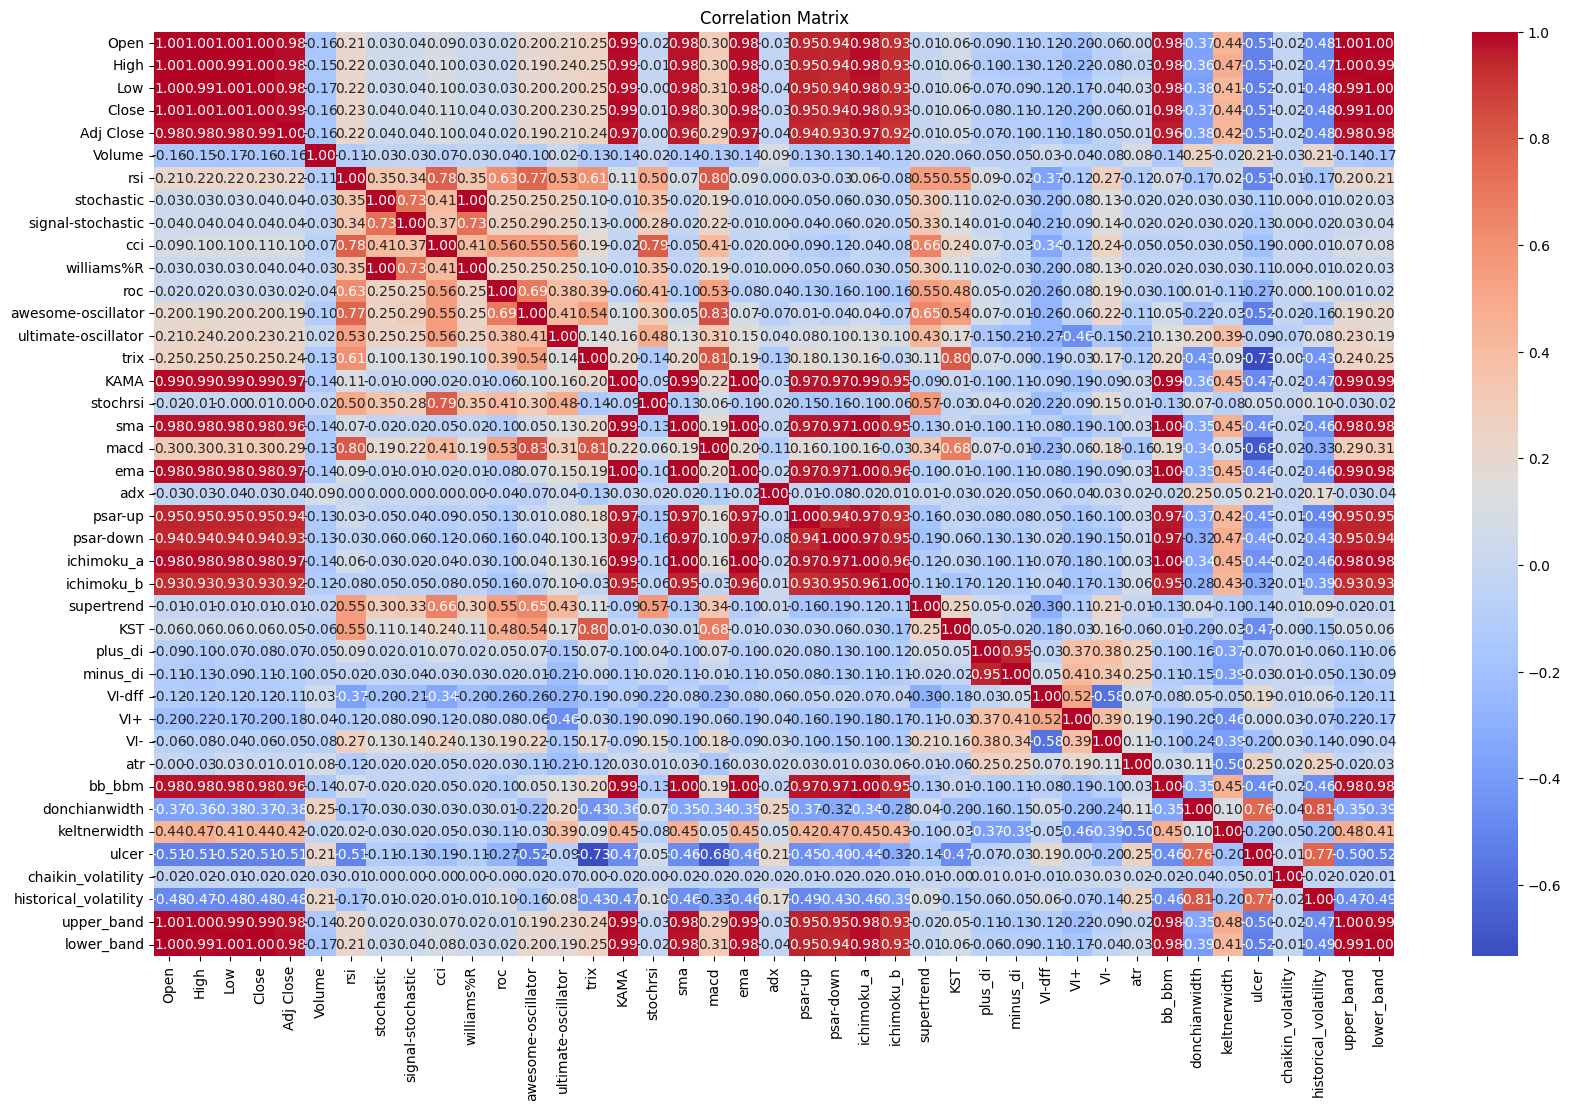

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','rsi','stochastic','signal-stochastic','cci', 'williams%R','roc','awesome-oscillator','ultimate-oscillator','trix','KAMA','stochrsi','sma','macd','ema','adx','psar-up','psar-down', 'ichimoku_a','ichimoku_b','supertrend','KST','plus_di','minus_di','VI-dff','VI+','VI-','atr','bb_bbm',
              'donchianwidth','keltnerwidth','ulcer','chaikin_volatility','historical_volatility','upper_band','lower_band']
plt.figure(figsize=(20, 12))
sns.heatmap(train_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [10]:
train_df.isnull().sum()
test_df.isnull().sum()

,0
Date,0
Ticker,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
return_14d,6936
rsi,0


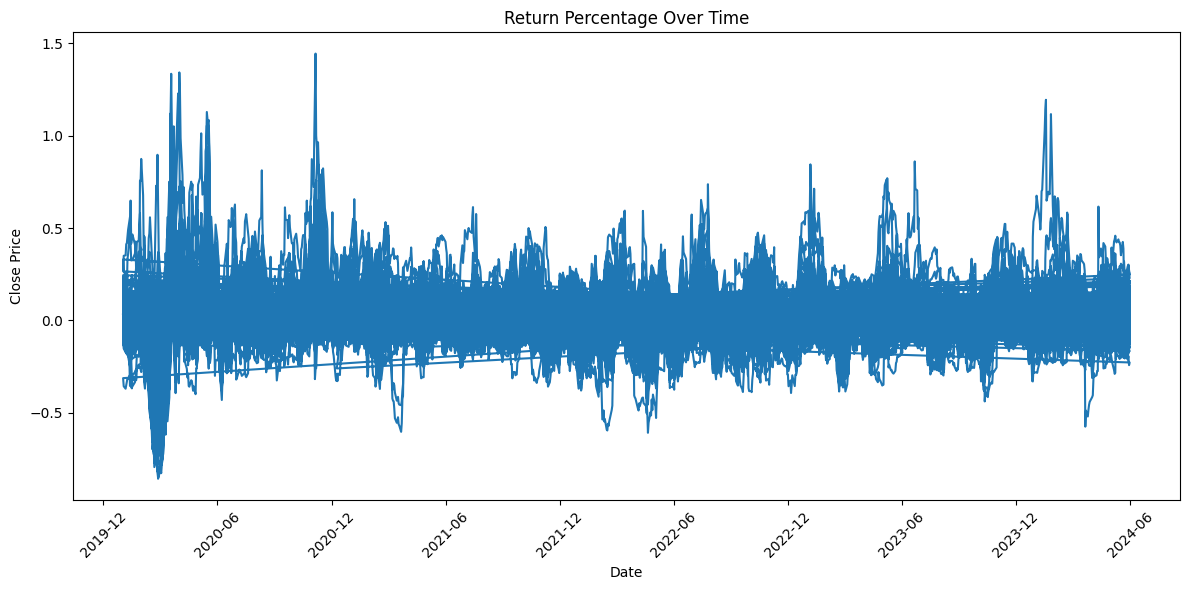

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

train_df['Date'] = pd.to_datetime(train_df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['return_14d'])

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('Return Percentage Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
